<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
[Warning] The CPU supports AVX2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports AVX but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.1 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSSE3 but the compiler does not.  Can you try another compiler?


Total time take = 2.84 s
Total time take = 2.9 s
Total time take = 2.78 s
Total time take = 2.89 s
Total time take = 3.18 s
Total time take = 2.96 s
Total time take = 3.0 s
Total time take = 2.97 s
Total time take = 2.88 s
Total time take = 2.88 s


Text(0, 0.5, '$\\xi$')

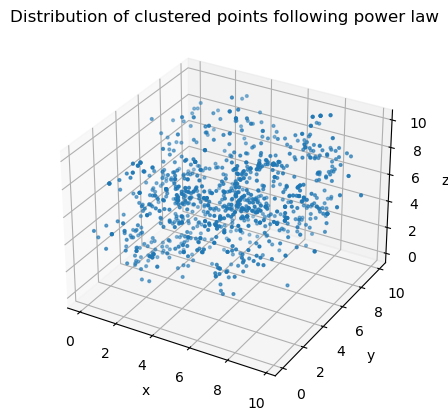

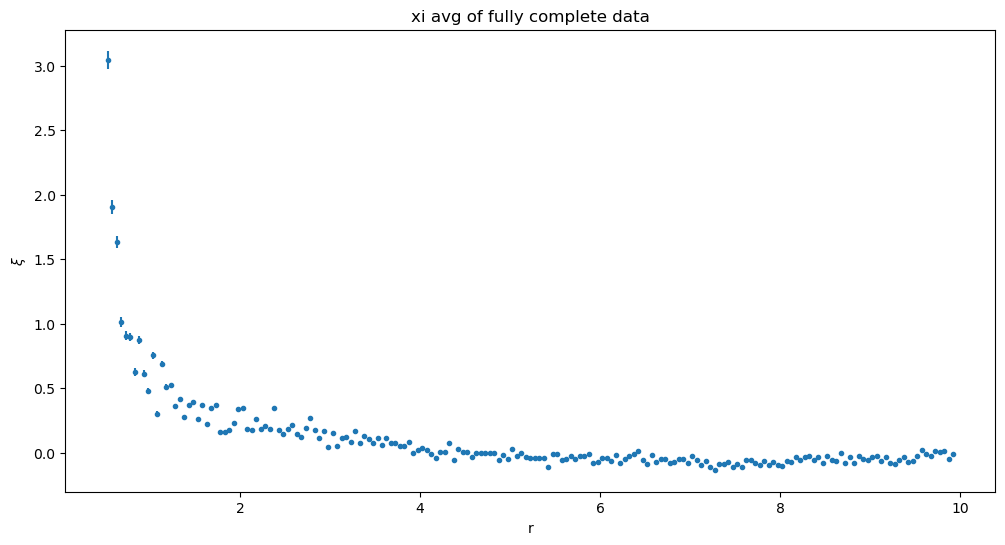

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Corrfunc.theory.DD import DD
import time
import numpy.ma as ma
import sys
import scipy.optimize as sp

sys.path.append('/home/vibin/MyFolder/WorkDesk/DP2/Codes/Clustering_analysis_PS1_and_shen')
from Clustering_module import *

DP2_DIRECTORY = "/home/vibin/MyFolder/WorkDesk/DP2/"

def p_corr_fun(r, r0, delta, r_min, r_max):
    #A = (1 - delta)/(pow(r0, delta) * (pow(r_max, 1 - delta) - pow(r_min, 1 - delta)))
    return pow(r/r0, -delta) 

xi_r = np.vectorize(p_corr_fun)

def get_r_from_prob(r0, delta, r_min, r_max):
    c = np.random.uniform(0, 1, 1)[0]
    A = (1 - delta)/(pow(r0, delta) * (pow(r_max, 1 - delta) - pow(r_min, 1 - delta)))
    temp1 = (1 - delta)/(A * pow(r0, delta)) * c + pow(r_min, 1 - delta)
    return pow(temp1, 1/(1 - delta))

get_r_from_prob_vec = np.vectorize(get_r_from_prob)

def make_clust_dist(num, r0, delta, box_size, r_min, r_max):
    dat_array = np.random.uniform(0, box_size, (3, 1))
    i = 0

    while i < (num - 1):
        r = get_r_from_prob(r0, delta, r_min, r_max)
        phi = np.random.uniform(0, 2 * np.pi, 1)[0]
        z = np.random.uniform(-r, r, 1)[0]
        theta = np.arccos(z/r)
        if np.isnan(theta):
            print(z/r)

        new_add = np.array([r * np.sin(theta) * np.cos(phi), r * np.sin(theta) * np.sin(phi), z])
        new_pt = np.reshape(dat_array[:,-1] + new_add, (3,1))
        if np.any(((new_pt < [[0], [0], [0]]) | (new_pt > [[box_size], [box_size], [box_size]]))):
            continue
        
        dat_array = np.append(dat_array, new_pt, axis=1)
        i += 1

    return dat_array

def make_clust_dist_v3(num, r0, delta, box_size, r_min, r_max, start_cond = None):
    if start_cond == 'center':
        dat_array = np.array([box_size/2, box_size/2, box_size/2]).reshape((3,1))
    else:
        dat_array = np.random.uniform(0, box_size, (3, 1))
    i = 0

    while i < (num - 1):
        r = get_r_from_prob(r0, delta, r_min, r_max)
        phi = np.random.uniform(0, 2 * np.pi, 1)[0]
        z = np.random.uniform(-r, r, 1)[0]
        theta = np.arccos(z/r)
        if np.isnan(theta):
            print(z/r)

        new_add = np.array([r * np.sin(theta) * np.cos(phi), r * np.sin(theta) * np.sin(phi), z])
        new_pt = np.reshape(dat_array[:,-1] + new_add, (3,1))
        if np.any(((new_pt < [[0], [0], [0]]) | (new_pt > [[box_size], [box_size], [box_size]]))):
            new_pt = np.reshape(dat_array[:,-1], (3,1))
        
        dat_array = np.append(dat_array, new_pt, axis=1)
        i += 1

    return dat_array

def quadrant(vel, box_size):
    if vel >= 0:
        return box_size
    else : 
        return 0

quadrant = np.vectorize(quadrant)

def make_clust_dist_v2(num, r0, delta, box_size, r_min, r_max):
    dat_array = np.random.uniform(0, box_size, (3, 1))
    i = 0

    while i < (num - 1):
        r = get_r_from_prob(r0, delta, r_min, r_max)
        phi = np.random.uniform(0, 2 * np.pi, 1)[0]
        z = np.random.uniform(-r, r, 1)[0]
        theta = np.arccos(z/r)
        if np.isnan(theta):
            print(z/r)

        new_add = np.array([r * np.sin(theta) * np.cos(phi), r * np.sin(theta) * np.sin(phi), z])
        new_pt = np.reshape(dat_array[:,-1] + new_add, (3,1))
        if np.any(((new_pt < [[0], [0], [0]]) | (new_pt > [[box_size], [box_size], [box_size]]))):
#------------------------------------------------------------------------------------------------------
            old_pt = dat_array[:,-1]

            vel = new_pt.flatten() - old_pt
            rem_dist = quadrant(vel, box_size) - old_pt
            print(vel, rem_dist)

            time_taken = np.min(rem_dist/vel)
            new_pt = np.reshape(vel * time_taken, (3,1))
#------------------------------------------------------------------------------------------------------
        
        dat_array = np.append(dat_array, new_pt, axis=1)
        i += 1

    return dat_array

def calc_corr_fun(x_dat, y_dat, z_dat, x_ran, y_ran, z_ran, bins):
    
    bin_avg = np.array((bins[:-1] + bins[1:])/2)

    results = DD(autocorr=1, nthreads=1, binfile=bins, X1=x_ran, Y1=y_ran, Z1=z_ran, periodic=False)
    results = np.array(list(map(list, results)))
    RR_count = results[:,3]/2
    #plt.stairs(RR_count, bins)

    results = DD(autocorr=1, nthreads=1, binfile=bins, X1=x_dat, Y1=y_dat, Z1=z_dat, periodic=False)
    results = np.array(list(map(list, results)))
    DD_count = results[:,3]/2
    #plt.stairs(DD_count, bins)

    results = DD(autocorr=0, nthreads=1, binfile=bins, X1=x_dat, Y1=y_dat, Z1=z_dat, X2=x_ran, Y2=y_ran, Z2=z_ran, periodic=False)
    results = np.array(list(map(list, results)))
    DR_count = results[:,3]
    #plt.stairs(DR_count, bins)

    DD_norm = (len(x_dat) * (len(x_dat) - 1))/2
    RR_norm = (len(x_ran) * (len(x_ran) - 1))/2
    DR_norm = len(x_dat) * len(x_ran)

    xi = ma.masked_values(DD_count * RR_count * DR_count, 0)
    error = ma.masked_values(DD_count * RR_count * DR_count, 0)
    xi[~xi.mask]= (DD_count[~xi.mask]/DD_norm - 2 * DR_count[~xi.mask]/DR_norm + RR_count[~xi.mask]/RR_norm)/ (RR_count[~xi.mask]/RR_norm)
    error[~error.mask] = (1 + xi[~xi.mask])/np.sqrt(np.minimum(DD_count[~xi.mask], len(x_dat)))
    

    fig, ax = plt.subplots(figsize=(7,7))
    ax.errorbar(bin_avg, xi, yerr=error, marker='.', ls='', label=r"$\xi$ of the simulation")
    
    if len(bin_avg[xi.mask]) != 0 :
        ax.plot(bin_avg[xi.mask], np.zeros_like(bin_avg[xi.mask]), 'r.', label="bins with any of the counts zero")
    ax.axhline(0)
    ax.set_xlabel('r')
    ax.set_ylabel(r'$\xi(r)$')

    ax.legend()
    return ax, xi, error

def Look_into(x_dat, y_dat, z_dat, r0_model, delta, n_d, n_r, bins, box_size, r_min, r_max):
    start = time.time()

    x_ran, y_ran, z_ran = np.random.uniform(0, box_size, (3, n_r))

    ax, xi, error = calc_corr_fun(x_dat, y_dat, z_dat, x_ran, y_ran, z_ran, bins)
    #ax.set_title("data with pow law clustering with $r_0$ = {}, $\delta$ = {}, $n_d$ = {}, $n_r$ = {}, box size = {}\n data density = {}".format(r0, delta, n_d, n_r, box_size, (n_d/ pow(box_size,3))))

    bin_avg = np.array((bins[:-1] + bins[1:])/2)
    r_vals = bin_avg
    xi_vals = xi_r(r_vals, r0_model, delta, r_min, r_max)

    ax.plot(r_vals, xi_vals, label="pow law function")

    end = time.time()
    print("Total time take = {} s".format(round(end-start,2)))

    return ax, xi, error

def Look_into_v2(x_dat, y_dat, z_dat, x_ran, y_ran, z_ran, r0_model, delta, n_d, bins, box_size, r_min, r_max):
    start = time.time()

    ax, xi, error = calc_corr_fun(x_dat, y_dat, z_dat, x_ran, y_ran, z_ran, bins)
    #ax.set_title("data with pow law clustering with $r_0$ = {}, $\delta$ = {}, $n_d$ = {}, $n_r$ = {}, box size = {}\n data density = {}".format(r0, delta, n_d, n_r, box_size, (n_d/ pow(box_size,3))))

    bin_avg = np.array((bins[:-1] + bins[1:])/2)
    r_vals = bin_avg
    xi_vals = xi_r(r_vals, r0_model, delta, r_min, r_max)

    ax.plot(r_vals, xi_vals, label="pow law function")

    end = time.time()
    print("Total time take = {} s".format(round(end-start,2)))

    return ax, xi, error


file_name = "mock_data_v1.npy"
data = np.load(file_name)

x_dat2, y_dat2, z_dat2 = data

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x_dat2, y_dat2, z_dat2, s=4)
#ax.plot(x_dat2, y_dat2, z_dat2, c='r', lw=0.5)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title("Distribution of clustered points following power law")


n_d = len(x_dat2)
r0_model = 1.0
delta = 2.0
box_size = 10

r_min, r_max = 0.5, 10

n_r = 10 * n_d
bin_start = 0.5
bin_end = 10
bin_width = 0.05

bins = np.arange(bin_start, bin_end, bin_width)
bin_avg = np.array((bins[:-1] + bins[1:])/2)


xi = np.zeros((10, len(bins)-1))
error = np.zeros((10, len(bins)-1))
for i in range(10):
    grade = np.arange(0, 10.1, 0.1)
    compl_map = np.ones_like(grade[:-1])

    x_dat_incompl = np.array([])
    y_dat_incompl = np.array([])
    z_dat_incompl = np.array([])

    for j in range(len(compl_map)):
        ind = np.where((z_dat2 >= grade[j]) & (z_dat2 < grade[j+1]))
        num = len(ind[0])
        req_num = int(num * compl_map[j])

        taken = np.random.choice(ind[0], req_num)
        z_dat_incompl = np.append(z_dat_incompl, (z_dat2[taken]))
        x_dat_incompl = np.append(x_dat_incompl, (x_dat2[taken]))
        y_dat_incompl = np.append(y_dat_incompl, (y_dat2[taken]))

    ax, xi_, error_ = Look_into(x_dat_incompl, y_dat_incompl, z_dat_incompl, r0_model = r0_model, delta = delta, n_d = n_d, n_r = n_r, bins=bins, box_size=box_size, r_min=r_min, r_max=r_max);
    xi[i] = xi_
    error[i] = error_
    plt.close()

fig, ax = plt.subplots(figsize=(12,6))

xi_avg = np.average(xi, axis=0)
error_avg = np.sqrt(np.average(error**2, axis=0)/len(error))

ax.errorbar(bin_avg, xi_avg, yerr=error_avg, marker='.', ls='')
ax.set_title("xi avg of fully complete data")
ax.set_xlabel("r")
ax.set_ylabel(r"$\xi$")

In [2]:
def completness_map_effects_without_ran_adjust(x_dat2, y_dat2, z_dat2, compl_map):
    fig, ax_com = plt.subplots(figsize=(8,6))

    ax_com.stairs(compl_map, grade, fill=True)
    ax_com.set_title("Completeness map")
    ax_com.set_ylabel("Completeness")
    ax_com.set_xlabel("z")

    xi2 = np.zeros((10, len(bins)-1))
    error2 = np.zeros((10, len(bins)-1))
    for i in range(10):

        x_dat_incompl = np.array([])
        y_dat_incompl = np.array([])
        z_dat_incompl = np.array([])

        for j in range(len(compl_map)):
            ind = np.where((z_dat2 >= grade[j]) & (z_dat2 < grade[j+1]))
            num = len(ind[0])
            req_num = int(num * compl_map[j])

            taken = np.random.choice(ind[0], req_num)
            z_dat_incompl = np.append(z_dat_incompl, (z_dat2[taken]))
            x_dat_incompl = np.append(x_dat_incompl, (x_dat2[taken]))
            y_dat_incompl = np.append(y_dat_incompl, (y_dat2[taken]))

        ax, xi_, error_ = Look_into(x_dat_incompl, y_dat_incompl, z_dat_incompl, r0_model = r0_model, delta = delta, n_d = n_d, n_r = n_r, bins=bins, box_size=box_size, r_min=r_min, r_max=r_max);
        xi2[i] = xi_
        error2[i] = error_
        plt.close()

    print("The number of data points retained =", len(z_dat_incompl))

    return xi2, error2

def completness_map_effects_with_ran_adjust(x_dat2, y_dat2, z_dat2, compl_map):
    fig, ax_com = plt.subplots(figsize=(8,6))

    ax_com.stairs(compl_map, grade, fill=True)
    ax_com.set_title("Completeness map")
    ax_com.set_ylabel("Completeness")
    ax_com.set_xlabel("z")

    xi3 = np.zeros((10, len(bins)-1))
    error3 = np.zeros((10, len(bins)-1))
    for i in range(10):

        x_ran, y_ran, z_ran = np.random.uniform(0, box_size, (3, n_r))
        x_ran_incompl = np.array([])
        y_ran_incompl = np.array([])
        z_ran_incompl = np.array([])

        x_dat_incompl = np.array([])
        y_dat_incompl = np.array([])
        z_dat_incompl = np.array([])

        for j in range(len(compl_map)):
            ind = np.where((z_dat2 >= grade[j]) & (z_dat2 < grade[j+1]))
            ind_ran = np.where((z_ran >= grade[j]) & (z_ran < grade[j+1]))
            num = len(ind[0])
            num_ran = len(ind_ran[0])
            req_num = int(num * compl_map[j])
            req_num_ran = int(num_ran * compl_map[j])

            taken = np.random.choice(ind[0], req_num)
            z_dat_incompl = np.append(z_dat_incompl, (z_dat2[taken]))
            x_dat_incompl = np.append(x_dat_incompl, (x_dat2[taken]))
            y_dat_incompl = np.append(y_dat_incompl, (y_dat2[taken]))

            taken_ran = np.random.choice(ind_ran[0], req_num_ran)
            z_ran_incompl = np.append(z_ran_incompl, (z_ran[taken_ran]))
            x_ran_incompl = np.append(x_ran_incompl, (x_ran[taken_ran]))
            y_ran_incompl = np.append(y_ran_incompl, (y_ran[taken_ran]))


        ax, xi_, error_ = Look_into_v2(x_dat_incompl, y_dat_incompl, z_dat_incompl, x_ran_incompl, y_ran_incompl, z_ran_incompl, r0_model = r0_model, delta = delta, n_d = n_d, bins=bins, box_size=box_size, r_min=r_min, r_max=r_max);
        xi3[i] = xi_
        error3[i] = error_
        plt.close()

    print("The number of data points retained =", len(z_dat_incompl))

    return xi3, error3

def compare_compl_effect_with_original(xi2, error2, xi, error, title=None):
    fig, (ax, ax_bot) = plt.subplots(2,1,figsize=(12,8), height_ratios=(5,3), sharex=True)

    xi_avg = np.average(xi, axis=0)
    error_avg = np.sqrt(np.average(error**2, axis=0)/len(error))

    ax.errorbar(bin_avg, xi_avg, yerr=error_avg, marker='.', ls='', label="Complete data")

    xi_avg2 = np.average(xi2, axis=0)
    error_avg2 = np.sqrt(np.average(error2**2, axis=0)/len(error))

    ax.errorbar(bin_avg, xi_avg2, yerr=error_avg2, marker='.', ls='', label="incomplete data")
    ax.set_title(title)
    ax.set_xlabel("r")
    ax.set_ylabel(r"$\xi$")
    ax.legend()

    diff_xi = (xi_avg2 - xi_avg)/((error_avg + error_avg2)/2)

    ax_bot.plot(bin_avg, diff_xi, marker='.', ls='')
    ax_bot.axhline(0, ls='--')
    ax_bot.axhline(2, ls='--')
    ax_bot.axhline(-2, ls='--')
    ax_bot.set_xlabel("r")
    ax_bot.set_ylabel("diff/err")

    return diff_xi


Total time take = 3.01 s
Total time take = 2.85 s
Total time take = 3.03 s
Total time take = 3.05 s
Total time take = 3.09 s
Total time take = 3.05 s
Total time take = 2.96 s
Total time take = 2.99 s
Total time take = 3.06 s
Total time take = 2.92 s
The number of data points retained = 1000


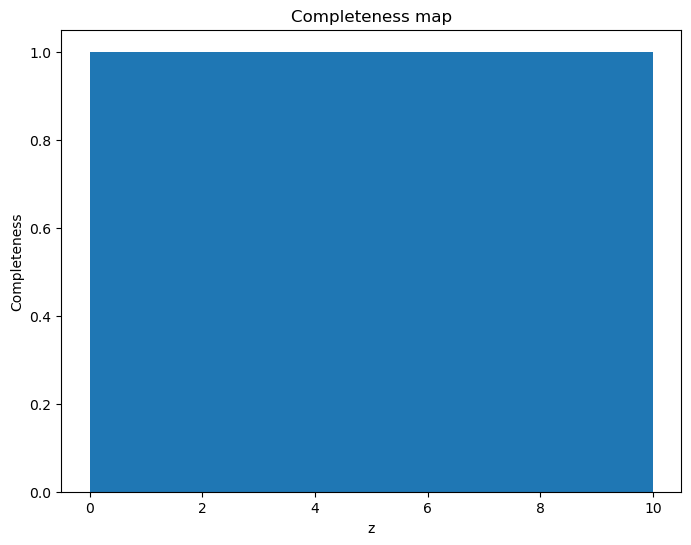

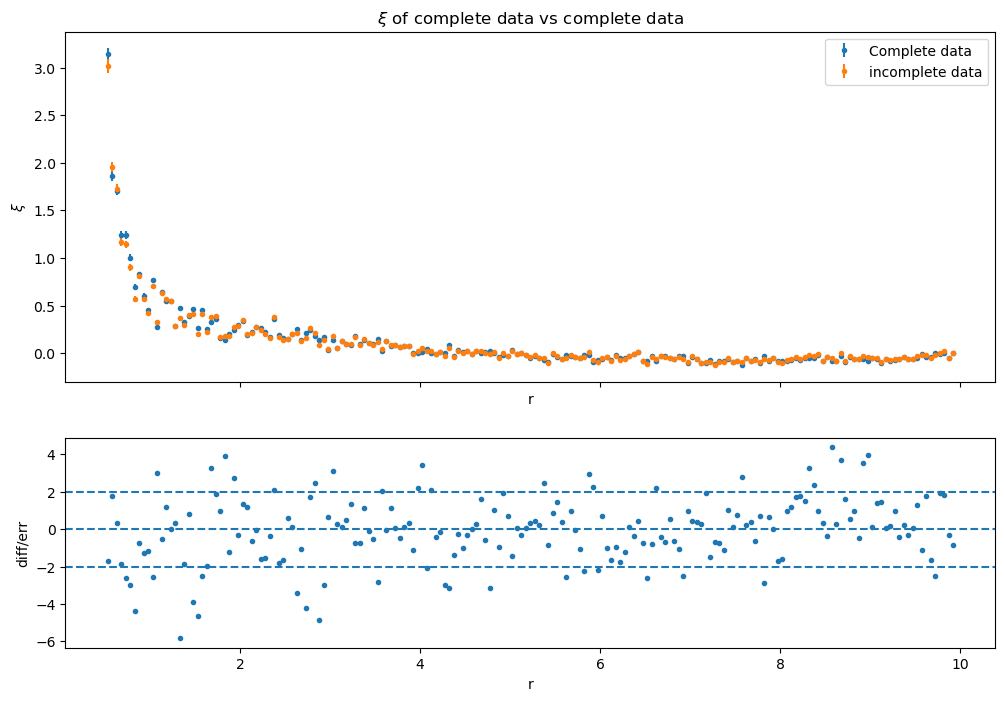

In [25]:
grade = np.arange(0, 10.1, 0.1)
compl_map = np.ones_like(grade[:-1])

xi2, error2 = completness_map_effects_without_ran_adjust(x_dat2, y_dat2, z_dat2, compl_map)

compare_compl_effect_with_original(xi2, error2, xi, error, title=r"$\xi$ of complete data vs complete data")

Total time take = 2.77 s
Total time take = 2.66 s
Total time take = 2.7 s
Total time take = 2.71 s
Total time take = 2.77 s
Total time take = 2.76 s
Total time take = 2.73 s
Total time take = 2.61 s
Total time take = 2.89 s
Total time take = 3.02 s
The number of data points retained = 747


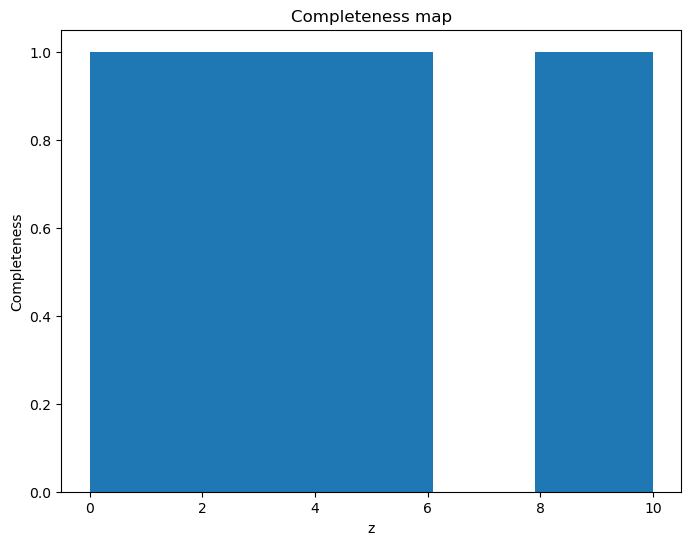

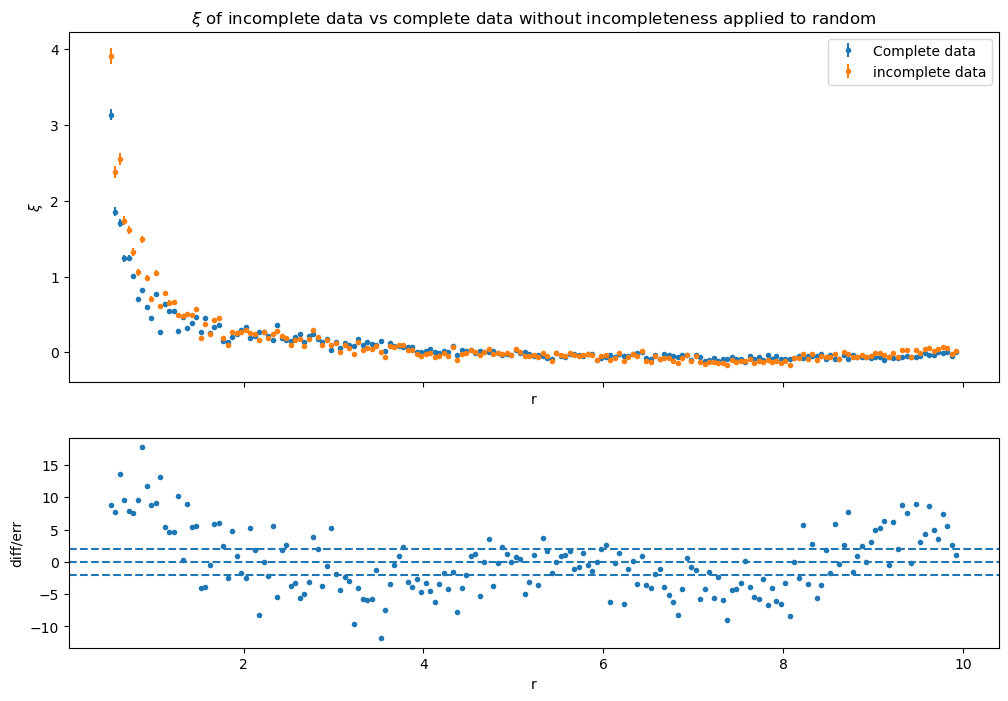

In [24]:
grade = np.arange(0, 10.1, 0.1)
compl_map = np.ones_like(grade[:-1])
grade_avg = np.array((grade[:-1] + grade[1:])/2)
ind = np.where((grade > 6) & (grade < 8))[0]
compl_map[ind[np.where((ind[1:] - ind[:-1]) == 1)]] = 0

xi2, error2 = completness_map_effects_without_ran_adjust(x_dat2, y_dat2, z_dat2, compl_map)

compare_compl_effect_with_original(xi2, error2, xi, error, title=r"$\xi$ of incomplete data vs complete data without incompleteness applied to random")

Total time take = 1.5 s
Total time take = 1.55 s
Total time take = 1.47 s
Total time take = 1.49 s
Total time take = 1.55 s
Total time take = 1.53 s
Total time take = 1.53 s
Total time take = 1.56 s
Total time take = 1.57 s
Total time take = 1.66 s
The number of data points retained = 747


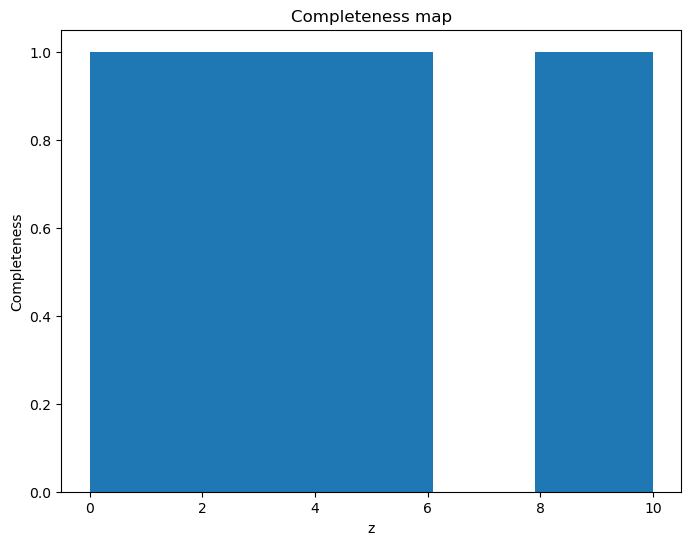

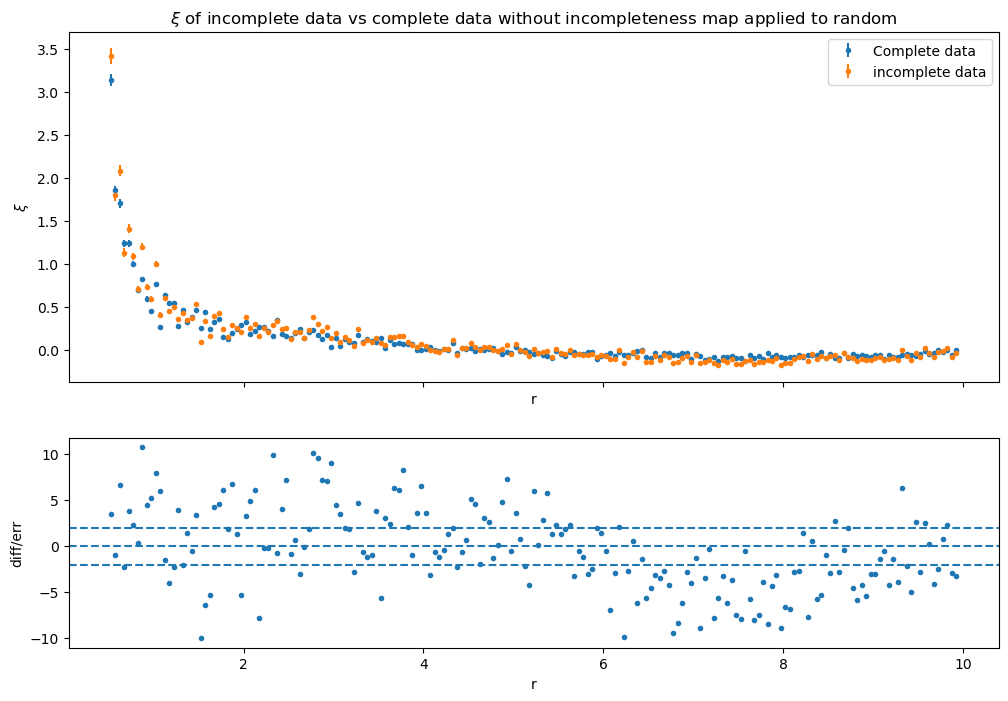

In [20]:
grade = np.arange(0, 10.1, 0.1)
compl_map = np.ones_like(grade[:-1])
grade_avg = np.array((grade[:-1] + grade[1:])/2)
ind = np.where((grade > 6) & (grade < 8))[0]
compl_map[ind[np.where((ind[1:] - ind[:-1]) == 1)]] = 0

xi2, error2 = completness_map_effects_with_ran_adjust(x_dat2, y_dat2, z_dat2, compl_map)

compare_compl_effect_with_original(xi2, error2, xi, error, title=r"$\xi$ of incomplete data vs complete data with incompleteness applied to random")

## Trying different completeness maps

Total time take = 1.79 s
Total time take = 1.85 s
Total time take = 1.95 s
Total time take = 1.92 s
Total time take = 1.93 s
Total time take = 1.97 s
Total time take = 1.89 s
Total time take = 1.94 s
Total time take = 2.07 s
Total time take = 1.92 s
The number of data points retained = 739


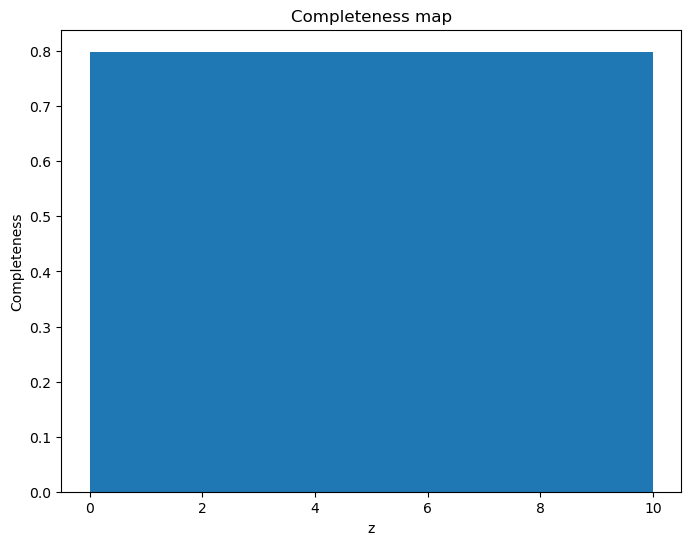

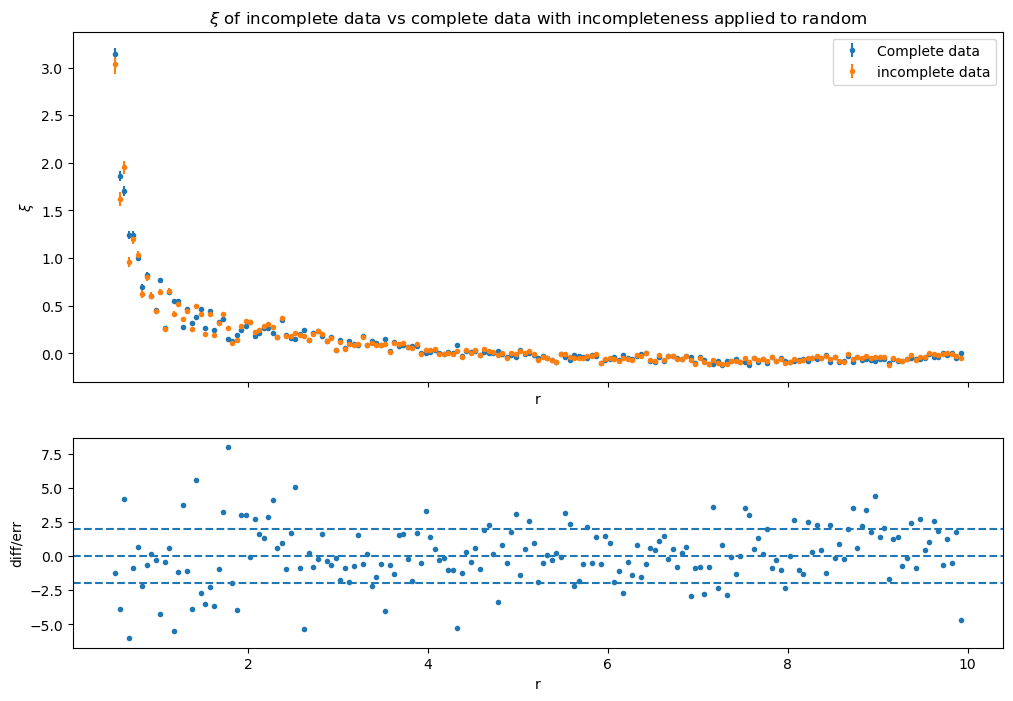

In [26]:
grade = np.arange(0, 10.1, 0.1)
compl_map = np.ones_like(grade[:-1])
grade_avg = np.array((grade[:-1] + grade[1:])/2)
ind = np.where((grade >= 0) & (grade <= 10))[0]
compl_map[ind[np.where((ind[1:] - ind[:-1]) == 1)]] = 0.799

xi2, error2 = completness_map_effects_with_ran_adjust(x_dat2, y_dat2, z_dat2, compl_map)

compare_compl_effect_with_original(xi2, error2, xi, error, title=r"$\xi$ of incomplete data vs complete data with incompleteness applied to random")

## Trying to fit the difference between $\xi$ of complete and incomplete data without random adjust

In [14]:
grade = np.arange(0, 10.1, 0.1)
compl_map = np.ones_like(grade[:-1])
grade_avg = np.array((grade[:-1] + grade[1:])/2)
ind = np.where((grade > 6) & (grade < 8))[0]
compl_map[ind[np.where((ind[1:] - ind[:-1]) == 1)]] = 0

xi2, error2 = completness_map_effects_without_ran_adjust(x_dat2, y_dat2, z_dat2, compl_map);
plt.close()

diff_xi = compare_compl_effect_with_original(xi2, error2, xi, error, title=r"$\xi$ of incomplete data vs complete data without incompleteness applied to random")
plt.close()

Total time take = 2.38 s
Total time take = 2.44 s
Total time take = 2.52 s
Total time take = 2.42 s
Total time take = 2.39 s
Total time take = 2.42 s
Total time take = 2.36 s
Total time take = 2.39 s
Total time take = 2.42 s
Total time take = 2.44 s
The number of data points retained = 747


Text(0, 0.5, 'diff/err')

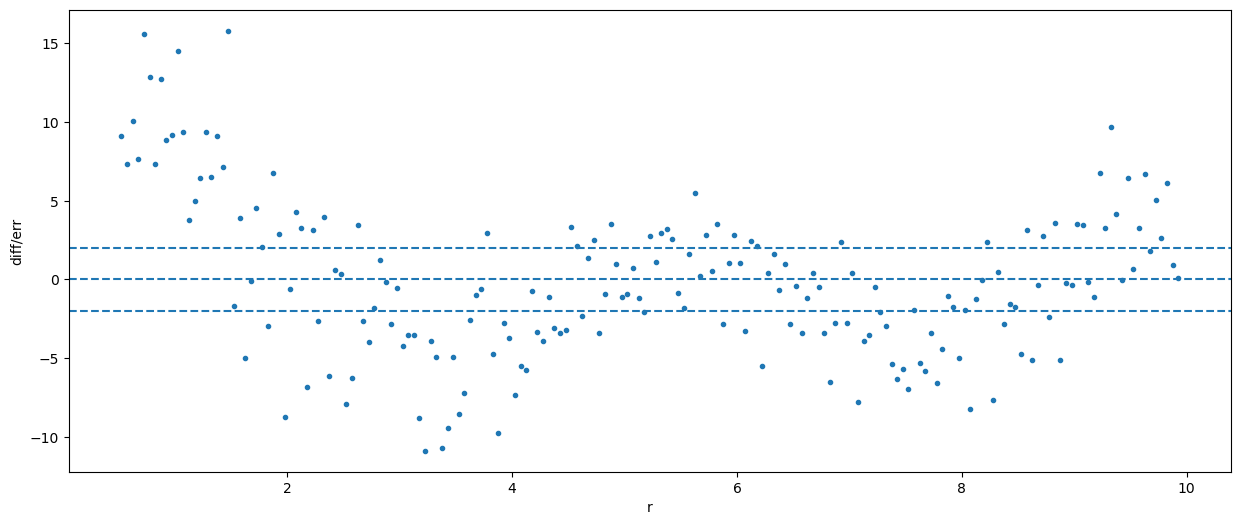

In [4]:
fig, ax_bot = plt.subplots(figsize = (15, 6))

ax_bot.plot(bin_avg, diff_xi, marker='.', ls='')
ax_bot.axhline(0, ls='--')
ax_bot.axhline(2, ls='--')
ax_bot.axhline(-2, ls='--')
ax_bot.set_xlabel("r")
ax_bot.set_ylabel("diff/err")

In [12]:
def fourier_fit_diff_xi(bin_avg, diff_xi, initial_guess):

    def fourier_series(x, w, a0, a1, a2, a3, a4, b1, b2, b3, b4):
        """Dynamically generated fitting function for Fourier series."""
        result = a0 + a1 * np.cos(w * x) + a2 * np.cos(2 * w * x) + a3 * np.cos(3 * w * x) \
                    + a4 * np.cos(4 * w * x) + b1 * np.sin(w * x) + b2 * np.sin(2 * w * x) \
                    + b3 * np.sin(3 * w * x) + b4 * np.sin(4 * w * x)
        
        return result

    fourier_series_v = np.vectorize(fourier_series)

    # Perform curve fitting
    params, _ = sp.curve_fit(fourier_series, bin_avg, diff_xi, p0=initial_guess)
    print(params)

    fig, ax = plt.subplots(figsize=(10,6))

    ax.plot(bin_avg, diff_xi, marker='.', ls='', label='Data points')

    y_fitted = fourier_series_v(bin_avg, *params)
    ax.plot(bin_avg, y_fitted, label='fitted with fourier 4')

    ax.set_ylabel("diff/err")
    ax.set_xlabel('r')
    ax.legend()

    return params

[ 0.4636912   5.01955934  9.95134473  3.93968124  1.30769054 -0.82705772
 -5.25105615 -5.35871073 -0.70847792 -1.75993054]


array([ 0.4636912 ,  5.01955934,  9.95134473,  3.93968124,  1.30769054,
       -0.82705772, -5.25105615, -5.35871073, -0.70847792, -1.75993054])

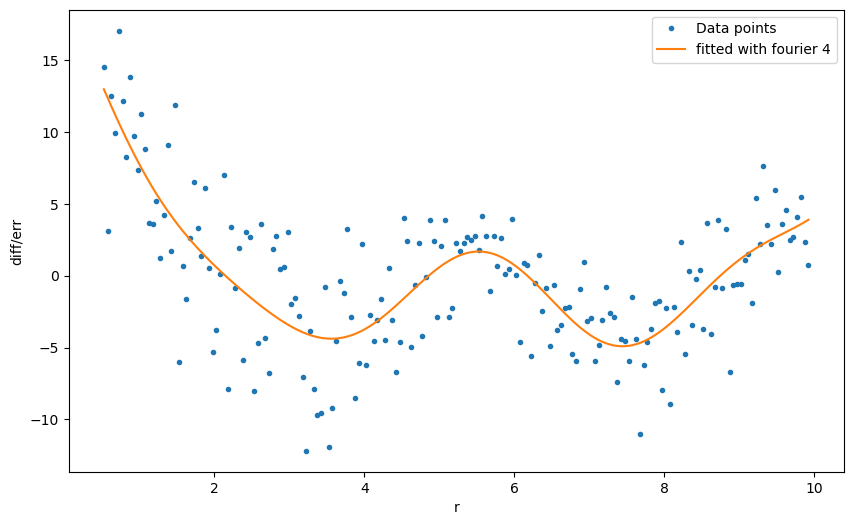

In [15]:
initial_guess = [0.5, 2, 4, 2, 2, 3, 5, 2, 2, 3]
fourier_fit_diff_xi(bin_avg, diff_xi, initial_guess)


In [16]:
grade = np.arange(0, 10.1, 0.1)
compl_map = np.ones_like(grade[:-1])
grade_avg = np.array((grade[:-1] + grade[1:])/2)
ind = np.where((grade > 6) & (grade < 8))[0]
compl_map[ind[np.where((ind[1:] - ind[:-1]) == 1)]] = 0.5

xi2, error2 = completness_map_effects_without_ran_adjust(x_dat2, y_dat2, z_dat2, compl_map);
plt.close()

diff_xi = compare_compl_effect_with_original(xi2, error2, xi, error, title=r"$\xi$ of incomplete data vs complete data without incompleteness applied to random")
plt.close()

Total time take = 2.4 s
Total time take = 2.47 s
Total time take = 2.62 s
Total time take = 2.51 s
Total time take = 2.69 s
Total time take = 2.55 s
Total time take = 2.72 s
Total time take = 2.76 s
Total time take = 2.75 s
Total time take = 2.62 s
The number of data points retained = 870


Text(0, 0.5, 'diff/err')

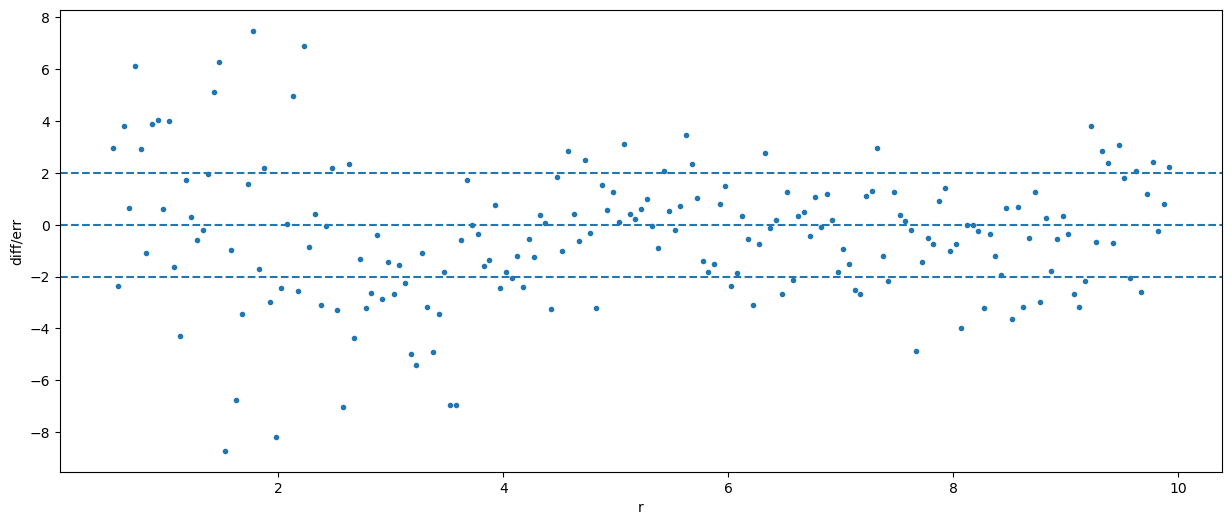

In [17]:
fig, ax_bot = plt.subplots(figsize = (15, 6))

ax_bot.plot(bin_avg, diff_xi, marker='.', ls='')
ax_bot.axhline(0, ls='--')
ax_bot.axhline(2, ls='--')
ax_bot.axhline(-2, ls='--')
ax_bot.set_xlabel("r")
ax_bot.set_ylabel("diff/err")

[ 0.63183913 -0.31458569  0.61369976  1.08273975 -0.18798889  0.51093694
 -0.30181109  0.92510069  0.28668647 -0.06852868]


array([ 0.63183913, -0.31458569,  0.61369976,  1.08273975, -0.18798889,
        0.51093694, -0.30181109,  0.92510069,  0.28668647, -0.06852868])

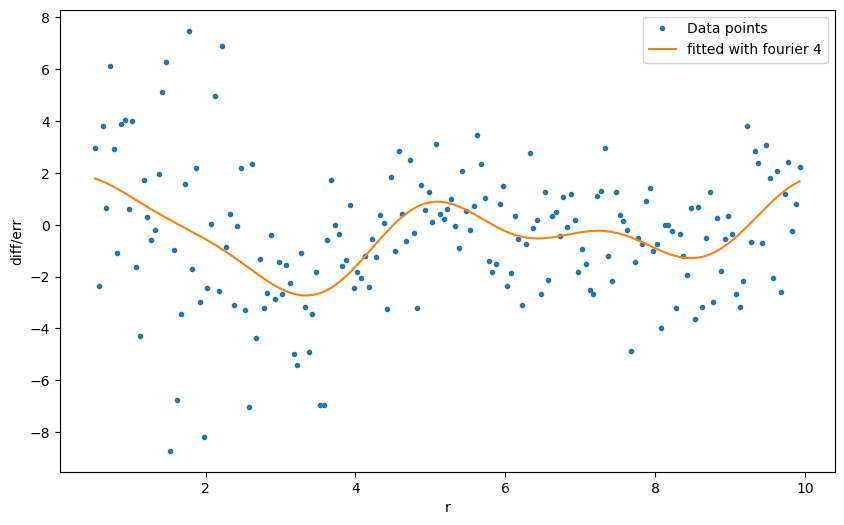

In [18]:
initial_guess = [0.5, 2, 4, 2, 2, 3, 5, 2, 2, 3]
fourier_fit_diff_xi(bin_avg, diff_xi, initial_guess)

## Incompleteness is applied to random field to check variation.

In [ ]:
box_size 